# Plotting hotspots of weather- (wind-) related incidents

In [1]:
import glob
import itertools
import math
import os
import re
import shutil

import PIL.Image
import fiona
import geopandas as gpd
import matplotlib.font_manager
import matplotlib.patches
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
from pysal.esda.mapclassify import Natural_Breaks as NBs
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import nearest_points

import database_met as dbm
import database_veg as dbv
import osm_utils
from converters import svg_to_emf
from utils import cdd, save, save_pickle, load_pickle, colorbar_index, confirmed

## Settings

In [2]:
import settings

settings.mpl_preferences(use_cambria=True, reset=False)
settings.np_preferences(reset=False)
settings.pd_preferences(reset=False)

original_wd = os.getcwd()

os.chdir(os.path.dirname(original_wd))

%matplotlib notebook

### Create a boundary based on specified bounds (llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat)

In [3]:
def create_boundary_polygon(bounds):
    """
    :param bounds: [tuple] (llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat)
    :return:
    """
    llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat = bounds
    boundary_polygon = Polygon([(llcrnrlon, llcrnrlat),
                                (llcrnrlon, urcrnrlat),
                                (urcrnrlon, urcrnrlat),
                                (urcrnrlon, llcrnrlat)])
    return boundary_polygon


### Get the path to .shp file for basemap loading

In [4]:
def get_shp_file_path_for_basemap(subregion, layer, feature=None, boundary=None, update=False):
    try:
        path_to_original_shp = osm_utils.fetch_osm_file(subregion, layer, feature, file_format=".shp")[0]
    except IndexError:
        shp_data = osm_utils.read_shp_zip(subregion, layer, feature, update)
        if isinstance(shp_data, list):
            shp_data = [dat for dat in shp_data if len(dat) == max(len(dat) for dat in shp_data)][0]
        shp_data.crs = {'no_defs': True, 'ellps': 'WGS84', 'datum': 'WGS84', 'proj': 'longlat'}

        shp_file_lst = osm_utils.fetch_osm_file(subregion, layer, feature=None)
        if len(shp_file_lst) > 1:
            shp_file_lst = [f for f in shp_file_lst if not re.match('.*_a_free_.*', f)]
        path_to_original_shp, shp_file = os.path.split(shp_file_lst[0])

        path_to_original_shp = os.path.join(path_to_original_shp, shp_file.replace(layer, layer + "_" + feature))
        shp_data.to_file(path_to_original_shp, driver='ESRI Shapefile')

    shape_file_dir, shape_filename = os.path.split(path_to_original_shp)

    new_shp_dir = cdd("Network\\OpenStreetMap", layer)

    if not os.path.exists(new_shp_dir):
        os.makedirs(new_shp_dir)

    for orig_file in glob.glob1(shape_file_dir, "{}.*".format(shape_filename.rstrip(".shp"))):
        dest_file = orig_file.replace("gis.osm", subregion)
        dest = os.path.join(new_shp_dir, dest_file)
        if not os.path.isfile(dest) or update:
            shutil.copyfile(os.path.join(shape_file_dir, orig_file), dest)
            print("'{}' copied, pasted as '{}'.".format(orig_file, dest_file))

    new_filename = shape_filename.replace("gis.osm", subregion).rstrip(".shp")
    new_path_to_shp = os.path.join(new_shp_dir, new_filename)

    if boundary is not None:
        subarea_shp = new_path_to_shp + "_subarea.shp"

        if not os.path.isfile(subarea_shp) or update:
            original_data = gpd.read_file(new_path_to_shp + ".shp")
            sub_idx = [i for i, x in enumerate(original_data.geometry) if x.intersects(boundary) or x.within(boundary)]
            subarea_data = original_data.loc[sub_idx]
            subarea_data.to_file(subarea_shp)

        new_path_to_shp, _ = os.path.splitext(subarea_shp)

    return new_path_to_shp


## Prep base maps

### Get the basemap ready

In [5]:
def plot_base_map(projection='tmerc', railway_line_color='#3d3d3d', legend_loc=(1.05, 0.85)):
    """
    :param projection: [str]
    :param railway_line_color: [str]
    :param legend_loc [tuple]
    :return:
    """
    print("Plotting the base map ... ", end="")
    plt.style.use('ggplot')  # Default, 'classic'; matplotlib.style.available gives the list of available styles
    fig = plt.figure(figsize=(9, 7))  # fig = plt.subplots(figsize=(11, 9))
    plt.subplots_adjust(left=0.001, bottom=0.000, right=0.6035, top=1.000)

    # Plot basemap
    base_map = Basemap(llcrnrlon=-0.565409,  # ll[0] - 0.06 * width,
                       llcrnrlat=51.23622,  # ll[1] - 0.06 + 0.002 * height,
                       urcrnrlon=1.915975,  # ur[0] + extra * width,
                       urcrnrlat=53.15000,  # ur[1] + extra + 0.01 * height,
                       ellps='WGS84',
                       lat_ts=0,
                       lon_0=-2.,
                       lat_0=49.,
                       projection=projection,  # Transverse Mercator Projection
                       resolution='i',
                       suppress_ticks=True,
                       epsg=27700)

    # base_map.arcgisimage(service='World_Shaded_Relief', xpixels=1500, dpi=300, verbose=False)
    base_map.drawmapboundary(color='white', fill_color='white')
    # base_map.drawcoastlines()
    base_map.fillcontinents(color='#dcdcdc')  # color='#555555'

    # Add a layer for railway tracks
    boundary_polygon = Polygon(zip(base_map.boundarylons, base_map.boundarylats))
    path_to_shp_file = get_shp_file_path_for_basemap('england', 'railways', 'rail', boundary_polygon)

    base_map.readshapefile(shapefile=path_to_shp_file,
                           name='anglia',
                           linewidth=1.2,
                           color=railway_line_color,  # '#626262', '#939393', '#757575', '#909090',
                           zorder=4)

    # Show legend
    plt.plot([], '-', label="Railway track", linewidth=2.2, color=railway_line_color)
    # font = {'family': 'Georgia', 'size': 16, 'weight': 'bold'}
    font = matplotlib.font_manager.FontProperties(family='Cambria', weight='normal', size=12)
    legend = plt.legend(numpoints=1, loc='best', prop=font, frameon=False, fancybox=True, bbox_to_anchor=legend_loc)
    frame = legend.get_frame()
    frame.set_edgecolor('none')
    frame.set_facecolor('none')

    print("Done.")

    return fig, base_map


Plotting the base map ... 

<IPython.core.display.Javascript object>


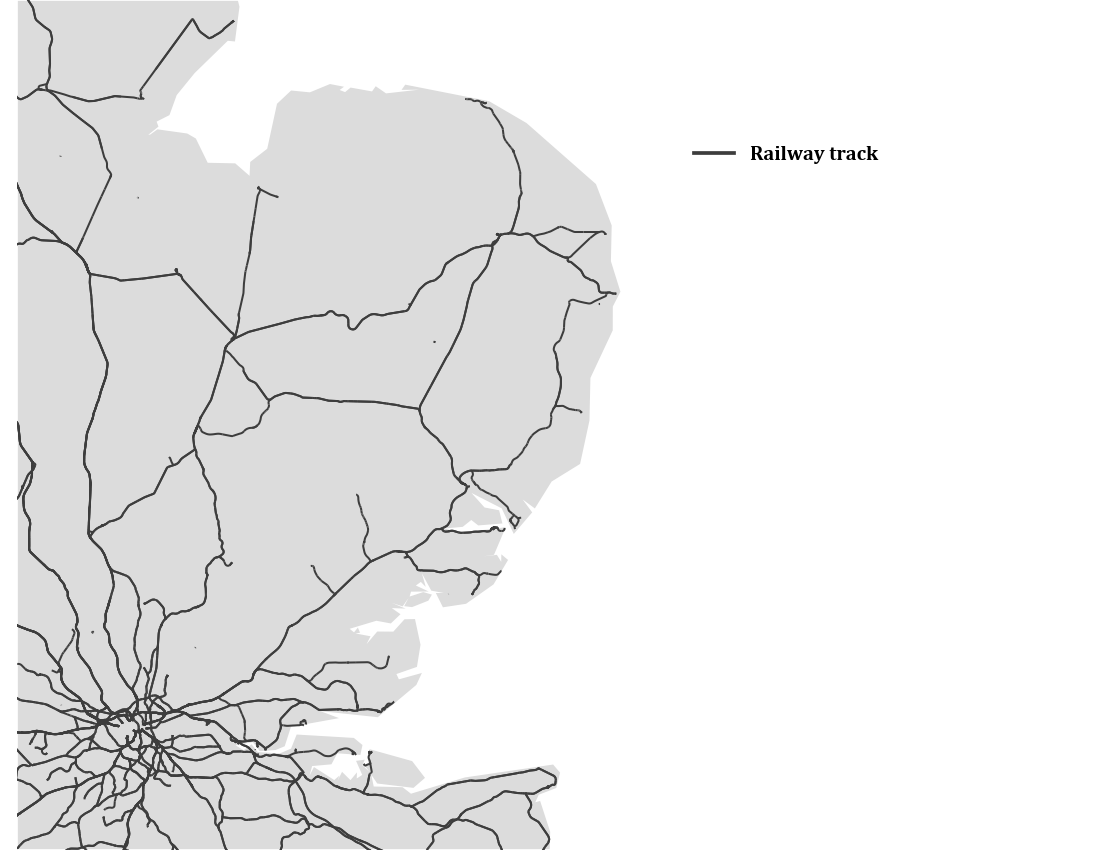

Done.


(<matplotlib.figure.Figure at 0x60df550>,
 <mpl_toolkits.basemap.Basemap at 0x5059b00>)

In [6]:
plot_base_map(projection='tmerc', railway_line_color='#3d3d3d', legend_loc=(1.05, 0.85))

### Show weather cells on the map

In [7]:
def plot_weather_cells(base_map=None, update=False, route=None, weather_cell_colour='#add6ff', legend_loc=(1.05, 0.85)):
    """
    :param base_map: [mpl_toolkits.basemap.Basemap] basemap object
    :param update: [bool]
    :param route: [str] Route
    :param weather_cell_colour: [str] default '#add6ff'; alternative '#99ccff', '#fff68f
    :param legend_loc [tuple]
    :return:
    """
    if base_map is None:
        _, base_map = plot_base_map()

    print("Plotting the weather cells ... ", end="")

    # Get weather cell data
    data = dbm.get_weather_cell(update=update)
    data = dbm.subset(data, route)
    # Drop duplicated weather cell data
    data.drop_duplicates(list(data.columns)[2:-1], inplace=True)

    # Plot the weather cells one by one
    for i in data.index:
        ll_x, ll_y = base_map(data.ll_Longitude[i], data.ll_Latitude[i])
        ul_x, ul_y = base_map(data.ul_lon[i], data.ul_lat[i])
        ur_x, ur_y = base_map(data.ur_Longitude[i], data.ur_Latitude[i])
        lr_x, lr_y = base_map(data.lr_lon[i], data.lr_lat[i])
        xy = zip([ll_x, ul_x, ur_x, lr_x], [ll_y, ul_y, ur_y, lr_y])
        p = matplotlib.patches.Polygon(list(xy), fc=weather_cell_colour, ec='#4b4747', alpha=.5, zorder=2)
        plt.gca().add_patch(p)

    # Add labels
    plt.plot([], 's', label="Weather cell", ms=18, color=weather_cell_colour, markeredgecolor='#433f3f', alpha=.5)

    # Show legend  # font = {'family': 'Georgia', 'size': 16, 'weight': 'bold'}
    font = matplotlib.font_manager.FontProperties(family='Cambria', weight='normal', size=12)
    plt.legend(numpoints=1, loc='best', prop=font, frameon=False, fancybox=True, bbox_to_anchor=legend_loc)

    print("Done.")
    

Plotting the base map ... 

<IPython.core.display.Javascript object>


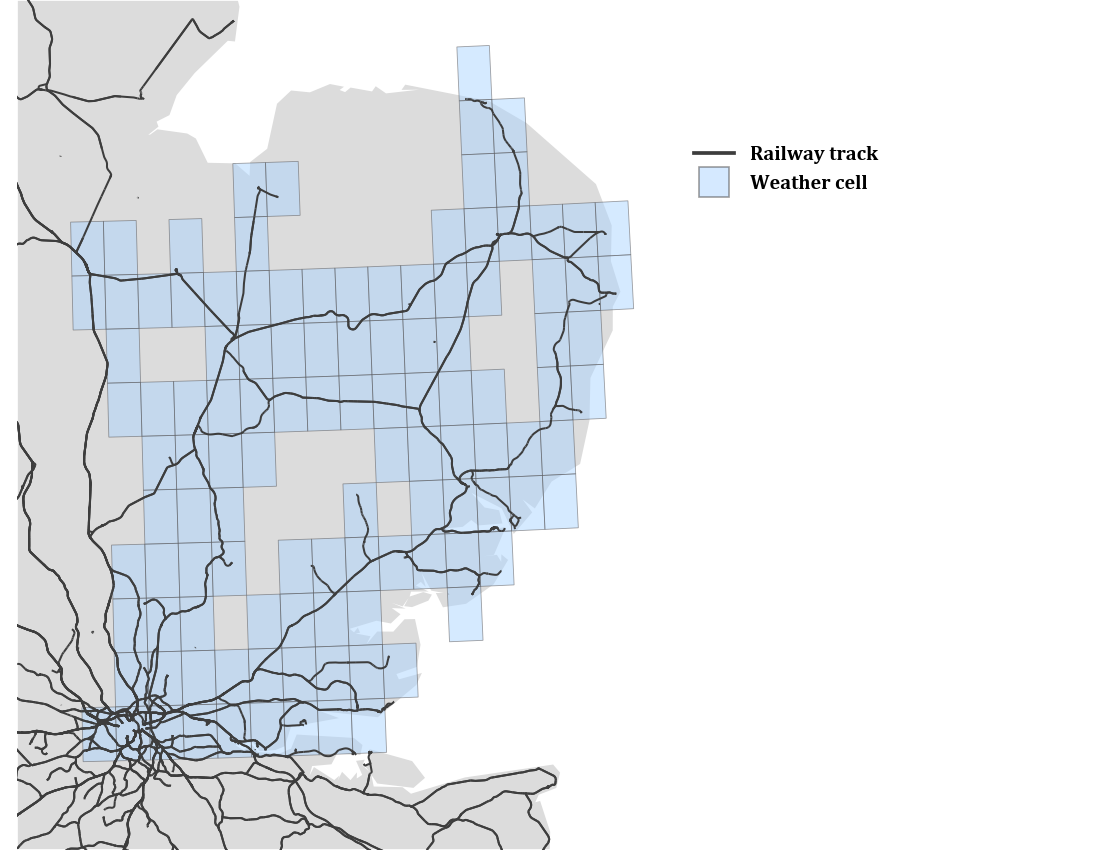

Done.
Plotting the weather cells ... Done.


In [8]:
plot_weather_cells(base_map=None, update=False, route=None, weather_cell_colour='#add6ff', legend_loc=(1.05, 0.85))

### Demonstrate the OSM natural forest on the map

In [9]:
def plot_osm_forest_and_tree(base_map=None, osm_landuse_forest_colour='#72886e', fill_forest_patches=False,
                             add_osm_natural_tree=False, legend_loc=(1.05, 0.85)):
    """
    :param base_map: default None
    :param osm_landuse_forest_colour: default '#7f987b'; alternatives '#8ea989', '#72946c', '#72946c'
    :param add_osm_natural_tree: default False
    :param fill_forest_patches: default False
    :param legend_loc [tuple]
    :return:
    """
    if base_map is None:
        _, base_map = plot_base_map()

    print("Plotting the OSM natural/forest ... ", end="")

    # OSM - landuse - forest
    boundary_polygon = Polygon(zip(base_map.boundarylons, base_map.boundarylats))
    bounded_landuse_forest_shp = get_shp_file_path_for_basemap('england', 'landuse', 'forest', boundary_polygon)

    base_map.readshapefile(bounded_landuse_forest_shp,
                           name='osm_landuse_forest',
                           color=osm_landuse_forest_colour,
                           zorder=3)

    # Fill the patches? Note this may take a long time and dramatically increase the file of the map
    if fill_forest_patches:
        print("\n")
        print("Filling the 'osm_landuse_forest' polygons ... ", end="")

        forest_polygons = [
            matplotlib.patches.Polygon(p, fc=osm_landuse_forest_colour, ec=osm_landuse_forest_colour, zorder=4)
            for p in base_map.osm_landuse_forest]

        for i in range(len(forest_polygons)):
            plt.gca().add_patch(forest_polygons[i])

    # OSM - natural - tree
    if add_osm_natural_tree:
        bounded_natural_tree_shp = get_shp_file_path_for_basemap('england', 'natural', 'tree', boundary_polygon)
        base_map.readshapefile(bounded_natural_tree_shp, name='osm_natural_tree')
        natural_tree_points = [Point(p) for p in base_map.osm_natural_tree]
        base_map.scatter([geom.x for geom in natural_tree_points], [geom.y for geom in natural_tree_points],
                         marker='o', s=2, facecolor='#008000', label="Tree", alpha=0.5, zorder=3)

    # Add label
    plt.scatter([], [], marker="o",
                # hatch=3 * "x", s=580,
                facecolor=osm_landuse_forest_colour, edgecolor='none',
                label="Vegetation (OSM 'forest')")

    # # Alternative 1:
    # plt.plot([], "o", ms=15, color=osm_landuse_forest_colour, markeredgecolor='none', alpha=.65,
    #          label="Vegetation (OSM 'forest')")

    # # Alternative 2:
    # plt.fill_between([], [], 0, label="Vegetation (OSM 'forest')", alpha=.65,
    #                  color=osm_landuse_forest_colour)

    # font = {'family': 'Georgia', 'size': 16, 'weight': 'bold'}
    font = matplotlib.font_manager.FontProperties(family='Cambria', weight='normal', size=12)
    plt.legend(scatterpoints=8, loc='best', prop=font, frameon=False, fancybox=True, bbox_to_anchor=legend_loc)

    print("Done.")


Plotting the base map ... 

<IPython.core.display.Javascript object>


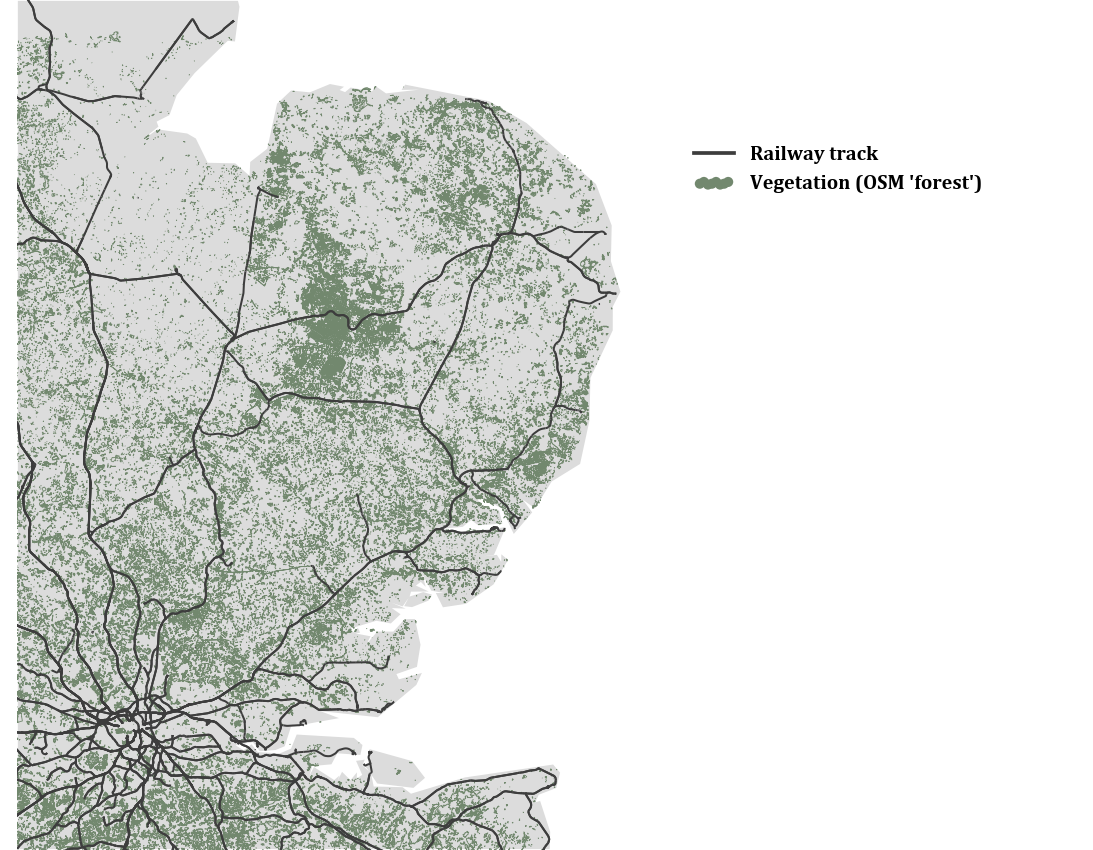

Done.
Plotting the OSM natural/forest ... Done.


In [10]:
plot_osm_forest_and_tree(base_map=None, osm_landuse_forest_colour='#72886e', fill_forest_patches=False,
                             add_osm_natural_tree=False, legend_loc=(1.05, 0.85))

### Show hazardous trees on the map

In [11]:
def plot_hazardous_trees(base_map=None, route=None, hazardous_tree_colour='#ab790a', legend_loc=(1.05, 0.85)):
    """
    :param base_map: 
    :param route: 
    :param hazardous_tree_colour: alternative '#886008', '#6e376e', '#5a7b6c'
    :param legend_loc:
    :return: 
    """
    if base_map is None:
        _, base_map = plot_base_map()

    print("Plotting the hazardous trees ... ", end="")

    hazardous_trees = dbv.get_hazardous_trees(route)

    map_points = [Point(base_map(long, lat)) for long, lat in zip(hazardous_trees.Longitude, hazardous_trees.Latitude)]
    hazardous_trees_points = MultiPoint(map_points)

    # Plot hazardous trees on the basemap
    base_map.scatter([geom.x for geom in hazardous_trees_points], [geom.y for geom in hazardous_trees_points],
                     marker='x',  # edgecolor='w',
                     s=12, lw=1.5, facecolor=hazardous_tree_colour,
                     label="Hazardous tress", alpha=0.6, antialiased=True, zorder=3)

    # Show legend  # setfont = {'family': 'Georgia', 'size': 16, 'weight': 'bold'}
    font = matplotlib.font_manager.FontProperties(family='Cambria', weight='normal', size=12)
    plt.legend(scatterpoints=5, loc='best', prop=font, frameon=False, fancybox=True, bbox_to_anchor=legend_loc)
    print("Done.")


Plotting the base map ... 

<IPython.core.display.Javascript object>


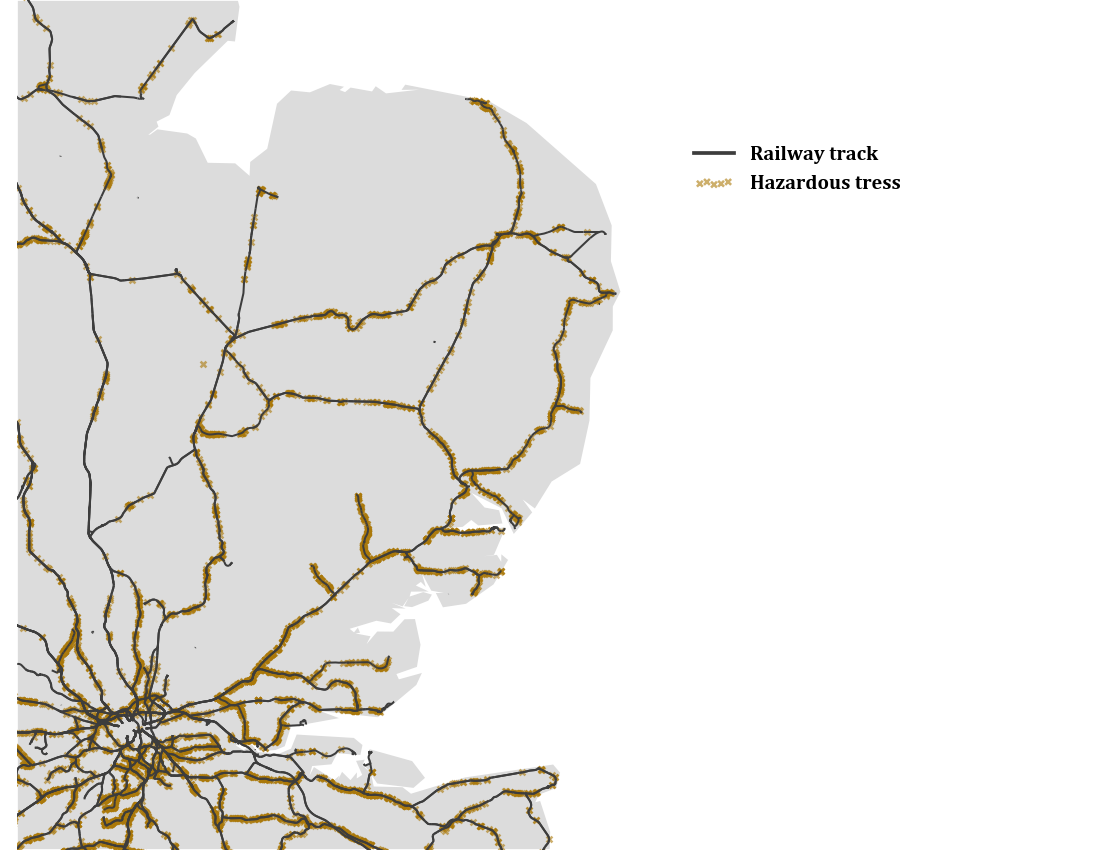

Done.
Plotting the hazardous trees ... Done.


In [12]:
plot_hazardous_trees(base_map=None, route=None, hazardous_tree_colour='#ab790a', legend_loc=(1.05, 0.85))

### Plot base map and associated features

In [13]:
def plot_base_map_plus(route='ANGLIA', show_metex_weather_cells=True, show_osm_landuse_forest=True,
                       add_osm_natural_tree=False, show_nr_hazardous_trees=True,
                       legend_loc=(1.05, 0.85), save_as=".png", dpi=None):
    # Plot basemap
    fig, base_map = plot_base_map(projection='tmerc', legend_loc=legend_loc)

    # Show weather cells
    if show_metex_weather_cells:
        plot_weather_cells(base_map, route=route, legend_loc=legend_loc)

    # Show vegetation
    if show_osm_landuse_forest:
        plot_osm_forest_and_tree(base_map, add_osm_natural_tree=add_osm_natural_tree, legend_loc=legend_loc)

    # Show hazardous trees
    if show_nr_hazardous_trees:
        plot_hazardous_trees(base_map, route=route, legend_loc=legend_loc)

    # Add a subplot of mini map of GB
    ax = plt.subplot()
    ax.plot(range(10))
    # Add an axes at position rect [left, bottom, width, height]
    sr = fig.add_axes([0.58, 0.01, 0.40, 0.40], frameon=True)  # quantities are in fractions of figure width and height
    sr.imshow(PIL.Image.open(cdd("Network\\Routes\\Map", "Routes-edited-0.png")))
    sr.axis('off')

    # Save the figure
    if save_as:
        print("Saving the figure ... ", end="")
        filename_suffix = zip([show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees],
                              ['cell', 'veg', 'haz'])
        fig_filename = '_'.join(['Basemap'] + [v for s, v in filename_suffix if s is True])
        fig.savefig(dbm.cdd_metex_db_fig_pub("01", "Basemap", fig_filename + save_as), dpi=dpi)
        print("Done.")
        if save_as == ".svg":
            svg_to_emf(dbm.cdd_metex_db_fig_pub("01", fig_filename + save_as),
                       dbm.cdd_metex_db_fig_pub("01", fig_filename + ".emf"))


Plotting the base map ... 

<IPython.core.display.Javascript object>


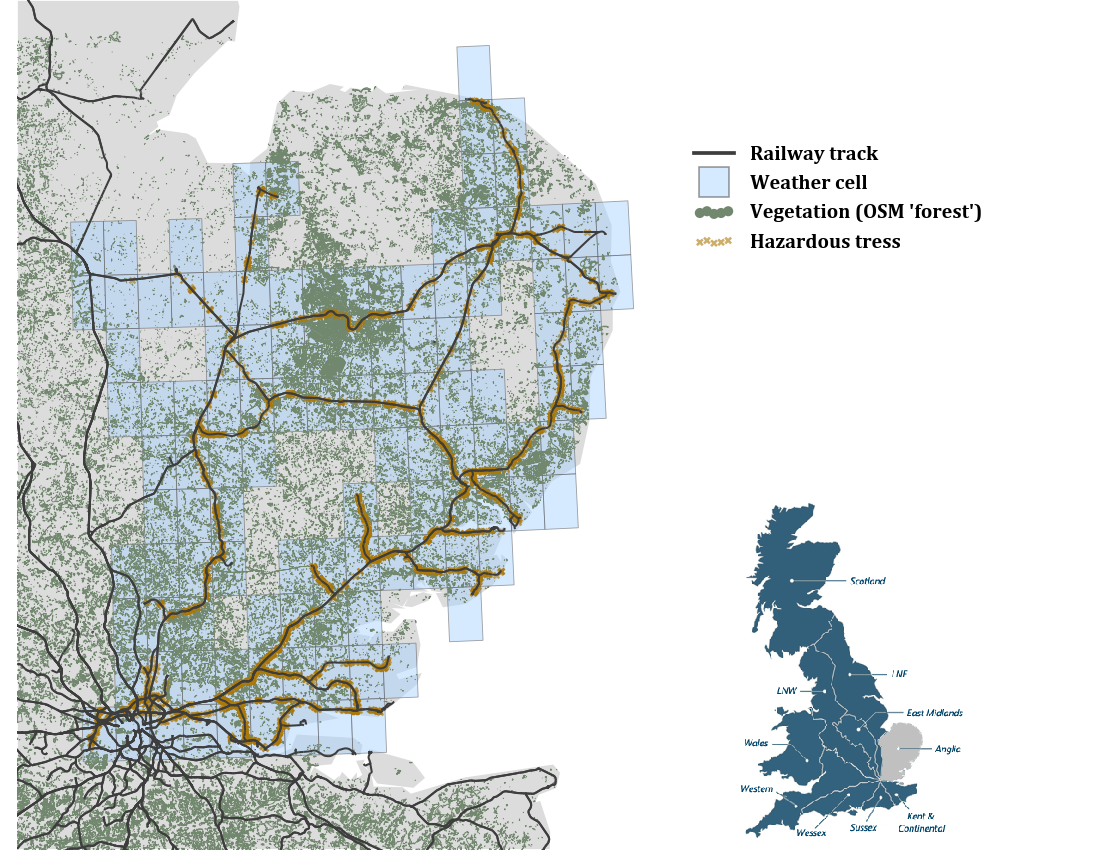

Done.
Plotting the weather cells ... Done.
Plotting the OSM natural/forest ... Done.
Plotting the hazardous trees ... Done.


In [14]:
plot_base_map_plus(route='ANGLIA', show_metex_weather_cells=True, show_osm_landuse_forest=True,
                       add_osm_natural_tree=False, show_nr_hazardous_trees=True,
                       legend_loc=(1.05, 0.85), save_as=None, dpi=None)

## Get 'hotspot' data

### Midpoint of two GPS points

In [15]:
def get_gps_midpoint(x_long, x_lat, y_long, y_lat):
    """
    :param x_long:
    :param x_lat:
    :param y_long:
    :param y_lat:
    :return:

    Reference:
    http://code.activestate.com/recipes/577713-midpoint-of-two-gps-points/
    http://www.movable-type.co.uk/scripts/latlong.html

    """
    # Input values as degrees, convert them to radians
    long_1, lat_1 = math.radians(x_long), math.radians(x_lat)
    long_2, lat_2 = math.radians(y_long), math.radians(y_lat)

    b_x, b_y = math.cos(lat_2) * math.cos(long_2 - long_1), math.cos(lat_2) * math.sin(long_2 - long_1)

    lat_3 = math.atan2(math.sin(lat_1) + math.sin(lat_2),
                       math.sqrt((math.cos(lat_1) + b_x) * (math.cos(lat_1) + b_x) + b_y ** 2))
    long_3 = long_1 + math.atan2(b_y, math.cos(lat_1) + b_x)

    midpoint = Point(math.degrees(long_3), math.degrees(lat_3))

    return midpoint


### Get midpoint between two points (given longitude and latitude)

In [16]:
def get_midpoint(start_point, end_point, as_geom=True):
    """
    :param start_point: [shapely.geometry.point.Point]
    :param end_point: [shapely.geometry.point.Point]
    :param as_geom: [bool]
    :return: 
    """
    midpoint = (start_point.x + end_point.x) / 2, (start_point.y + end_point.y) / 2
    return Point(midpoint) if as_geom else midpoint


### Get coordinates of points from a .shp file, by subregion, layer and feature

In [17]:
def get_point_coords_from_shp(subregion, layer, feature=None, update=False):
    """
    :param subregion: [str]
    :param layer: [str]
    :param feature: [str]
    :param update: [bool]
    :return:
    """
    _, download_url = osm_utils.get_download_url(subregion, file_format='.shp.zip')
    _, file_path = osm_utils.make_file_path(download_url)
    extract_dir = os.path.splitext(file_path)[0]
    path_to_shp_coords_pickle = osm_utils.make_osm_pickle_file_path(extract_dir, layer, feature, suffix='coords')

    if os.path.isfile(path_to_shp_coords_pickle) and not update:
        point_coords = load_pickle(path_to_shp_coords_pickle)
    else:
        try:
            railways_shp_data = osm_utils.read_shp_zip(subregion, layer, feature)
            point_coords = MultiPoint(list(itertools.chain(*(l.coords for l in railways_shp_data.geometry))))
        except Exception as e:
            print(e)
            point_coords = None
        save_pickle(point_coords, path_to_shp_coords_pickle)

    return point_coords


### Get the data for plotting

In [18]:
def get_schedule8_incident_hotspots(route=None, weather=None, sort_by=None, update=False):
    """
    :param route: [NoneType] or [str]
    :param weather: [NoneType] or [str]
    :param sort_by: [NoneType] or [list]
    :param update: [bool]
    :return:
    """
    path_to_file = dbm.cdd_metex_db_views("Hotspots.pickle")

    if os.path.isfile(path_to_file) and not update:
        hotspots_data = load_pickle(path_to_file)
    else:
        # Get TRUST (by incident location, i.e. by STANOX section)
        schedule8_costs_by_location = dbm.get_schedule8_costs_by_location(route=None, weather=None)
        schedule8_costs_by_location['StartPoint'] = [
            Point(long, lat) for long, lat in
            zip(schedule8_costs_by_location.StartLongitude, schedule8_costs_by_location.StartLatitude)]
        schedule8_costs_by_location['EndPoint'] = [
            Point(long, lat) for long, lat in
            zip(schedule8_costs_by_location.EndLongitude, schedule8_costs_by_location.EndLatitude)]

        # Find a pseudo midpoint for each recorded incident
        pseudo_midpoints = schedule8_costs_by_location[['StartPoint', 'EndPoint']].apply(
            lambda x: get_midpoint(x[0], x[1]), axis=1)

        # Get reference points (coordinates), given subregion and layer (i.e. 'railways' in this case) of OSM .shp file
        rail_points = get_point_coords_from_shp(subregion='england', layer='railways', feature='rail')

        subarea_shp = get_shp_file_path_for_basemap('england', 'railways', 'rail', boundary=True)
        subarea_shp_file = fiona.open(subarea_shp + ".shp")
        bounds = create_boundary_polygon(subarea_shp_file.bounds)
        subarea_shp_file.close()

        ref_points = MultiPoint([p for p in rail_points if p.within(bounds) or p.intersects(bounds)])

        # Get rail coordinates closest to the midpoints between starts and ends
        schedule8_costs_by_location['MidPoint'] = pseudo_midpoints.map(lambda x: nearest_points(x, ref_points)[1])

        midpoints = pd.DataFrame(((pt.x, pt.y) for pt in schedule8_costs_by_location.MidPoint),
                                 index=schedule8_costs_by_location.index,
                                 columns=['MidLongitude', 'MidLatitude'])

        hotspots_data = schedule8_costs_by_location.join(midpoints)

        save(hotspots_data, path_to_file)

    if sort_by:
        hotspots_data.sort_values(sort_by, ascending=False, inplace=True)

    hotspots_data = dbm.subset(hotspots_data, route, weather)
    hotspots_data.index = range(len(hotspots_data))

    return hotspots_data


## Plot 'hotspots'

### A function for saving the plots

In [19]:
def save_fig(fig, keyword, show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees, save_as, dpi):
    """
    :param fig: [matplotlib.figure.Figure]
    :param keyword: [str] a keyword for specifying the filename
    :param show_metex_weather_cells: [bool]
    :param show_osm_landuse_forest: [bool]
    :param show_nr_hazardous_trees: [bool]
    :param save_as: [str]
    :param dpi: [int] or None
    :return:
    """
    if save_as.lstrip('.') in fig.canvas.get_supported_filetypes():
        print("Saving the figure ... ", end="")
        fsuffix = zip([show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees],
                      ['cell', 'veg', 'haz'])
        filename = '_'.join(["Hotspots", keyword] + [v for s, v in fsuffix if s is True])
        path_to_file = dbm.cdd_metex_db_fig_pub("01", "Hotspots", filename + save_as)
        plt.savefig(path_to_file, dpi=dpi)
        print("Done.")
        if save_as == ".svg":
            svg_to_emf(path_to_file, path_to_file.replace(save_as, ".emf"))


### Plot hotspots of delays for every financial year (2006/07-2014/15)

In [20]:
def hotspots_delays_yearly(route='ANGLIA', weather='Wind', update=False,
                           cmap_name='Set1',
                           show_metex_weather_cells=False,
                           show_osm_landuse_forest=False,
                           show_nr_hazardous_trees=False,
                           save_as=".png", dpi=None):
    # Get data
    data_filename = "Hotspots_by_DelayMinutes_yearly.pickle"
    try:
        hotspots_data = dbm.subset(load_pickle(dbm.cdd_metex_db_views(data_filename)), route, weather)
    except FileNotFoundError:
        schedule8_data = dbm.get_schedule8_costs_by_datetime_location(route, weather, update)
        group_features = ['FinancialYear', 'WeatherCategory', 'Route', 'StanoxSection',
                          'StartLongitude', 'StartLatitude', 'EndLongitude', 'EndLatitude']
        schedule8_data = schedule8_data.groupby(group_features).aggregate(
            {'DelayMinutes': pd.np.sum, 'DelayCost': pd.np.sum, 'IncidentCount': pd.np.sum}).reset_index()
        hotspots = get_schedule8_incident_hotspots(route, weather)
        hotspots_data = schedule8_data.merge(
            hotspots[group_features[1:] + ['MidLatitude', 'MidLongitude']], how='left', on=group_features[1:])
        hotspots_data.sort_values(by=['DelayMinutes', 'DelayCost', 'IncidentCount'], ascending=False, inplace=True)
        save(hotspots_data, dbm.cdd_metex_db_views(data_filename))

    yearly_cost = hotspots_data.groupby('FinancialYear').aggregate(
        {'DelayMinutes': pd.np.sum, 'DelayCost': pd.np.sum, 'IncidentCount': pd.np.sum})

    # Labels
    years = [str(y) for y in yearly_cost.index]
    fyears = ['/'.join([y0, str(y1)[-2:]]) for y0, y1 in zip(years, pd.np.array(yearly_cost.index) + pd.np.array([1]))]

    dlabel = ["%s  (%s min." % (fy, format(int(d), ",")) for fy, d in zip(fyears, yearly_cost.DelayMinutes)]
    clabel = ["  / £%.2f" % round(c * 1e-6, 2) + "M)" for c in yearly_cost.DelayCost]
    label = [l for l in reversed([d + c for d, c in zip(dlabel, clabel)])]

    cmap = plt.get_cmap(cmap_name)
    colours = cmap(pd.np.linspace(start=0, stop=1, num=9))
    colours = [c for c in reversed(colours)]

    # Plot basemap (with railway tracks)
    fig, base_map = plot_base_map(legend_loc=(1.05, 0.9))
    fig.subplots_adjust(left=0.001, bottom=0.000, right=0.7715, top=1.000)

    top_hotspots = []
    for y, fy in zip(years, fyears):
        plot_data = hotspots_data[hotspots_data.FinancialYear == int(y)][0:20]
        top_hotspots.append(fy + ':  ' + plot_data.StanoxSection.iloc[0])
        for i in plot_data.index:
            mid_lat = plot_data.MidLatitude[i]
            mid_lon = plot_data.MidLongitude[i]
            mid_x, mid_y = base_map(mid_lon, mid_lat)
            base_map.plot(mid_x, mid_y, zorder=2, marker='o', color=colours[years.index(y)], alpha=0.9,
                          markersize=18, markeredgecolor='w')

    # Add a colour bar
    cb = colorbar_index(no_of_colours=len(label), cmap_param=cmap, shrink=0.4, labels=label, pad=0.068)
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_font_properties(matplotlib.font_manager.FontProperties(family='Times New Roman', weight='bold'))
    cb.ax.tick_params(labelsize=10)
    cb.set_alpha(1.0)
    cb.draw_all()

    cb.ax.text(0 + 1.5, 1.02, "Annual total delays and cost",
               ha='left', va='bottom', size=11, color='#555555', fontname='Cambria')

    #
    cb.ax.text(0, 0 - 0.18, "Locations with longest delays:",
               ha='left', va='bottom', size=11, color='#555555', weight='bold', fontname='Cambria')
    cb.ax.text(0, 0 - 0.75, "\n".join(top_hotspots),
               ha='left', va='bottom', size=10, color='#555555', fontname='Times New Roman')

    if show_metex_weather_cells:
        plot_weather_cells(base_map, route=route, legend_loc=(1.05, 0.95))

    if show_osm_landuse_forest:
        plot_osm_forest_and_tree(base_map, add_osm_natural_tree=False, legend_loc=(1.05, 0.96))

    if show_nr_hazardous_trees:
        plot_hazardous_trees(base_map, route=route, legend_loc=(1.05, 0.975))

    save_fig(fig, "annual_delays_cost",
             show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees, save_as, dpi)


Plotting the base map ... 

<IPython.core.display.Javascript object>


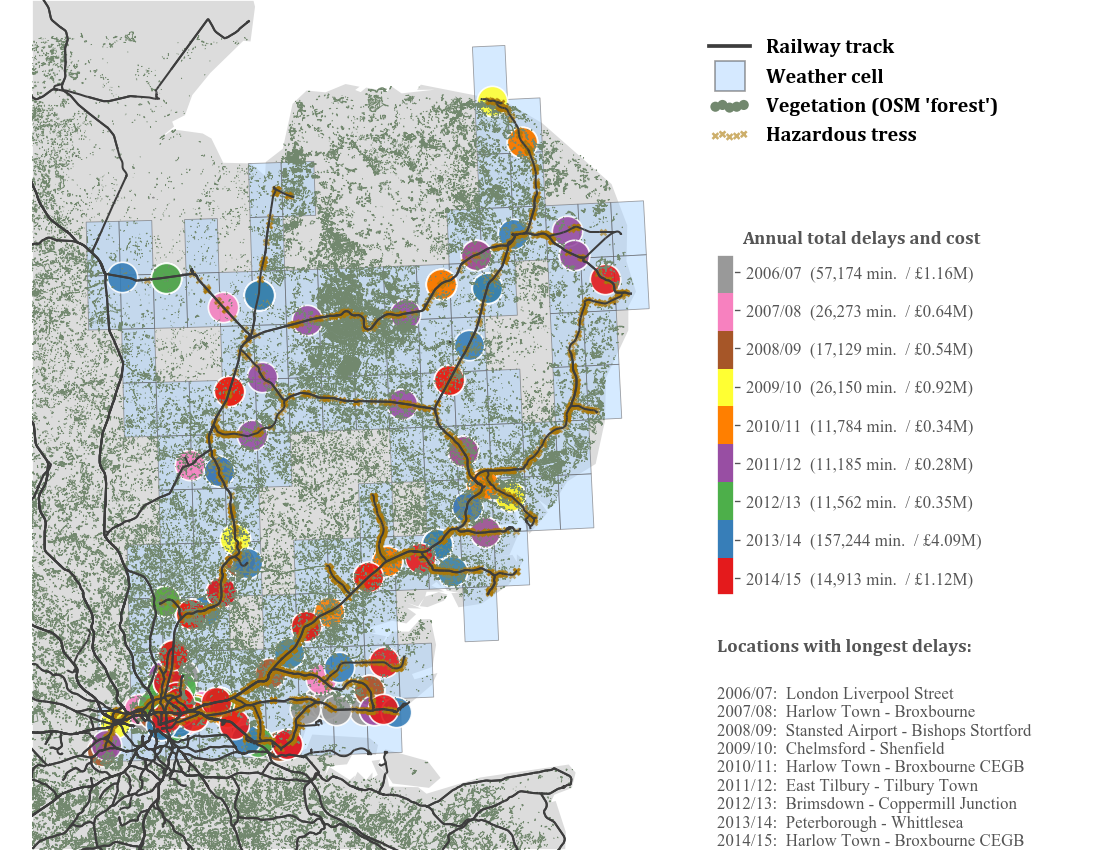

Done.
Plotting the weather cells ... Done.
Plotting the OSM natural/forest ... Done.
Plotting the hazardous trees ... Done.


In [21]:
hotspots_delays_yearly(route='ANGLIA', weather='Wind', update=False,
                           cmap_name='Set1',
                           show_metex_weather_cells=True,
                           show_osm_landuse_forest=True,
                           show_nr_hazardous_trees=True,
                           save_as="", dpi=None)

### Plot hotspots of delay minutes

In [22]:
def hotspots_delays(route='ANGLIA', weather='Wind', update=False,
                    seed=123,
                    cmap_name='Reds',
                    show_metex_weather_cells=False,
                    show_osm_landuse_forest=False,
                    show_nr_hazardous_trees=False,
                    save_as=".png", dpi=None):
    # Get hotspots data
    sort_by = ['DelayMinutes', 'IncidentCount', 'DelayCost']
    hotspots_data = get_schedule8_incident_hotspots(route, weather, sort_by, update)
    notnull_data = hotspots_data[hotspots_data.DelayMinutes.notnull()]

    # Set a seed number
    pd.np.random.seed(seed)

    # Calculate Jenks natural breaks for delay minutes
    breaks = NBs(y=notnull_data.DelayMinutes.values, k=6, initial=100)
    hotspots_data = hotspots_data.join(pd.DataFrame({'jenks_bins': breaks.yb}, index=notnull_data.index))
    # hotspots_data['jenks_bins'].fillna(-1, inplace=True)
    label = "<= %s min.  / %s locations"
    # bins = breaks.bins - np.array([np.remainder(b, 10 ** (len(str(int(b))) - 1)) for b in breaks.bins])
    # bins = np.insert(bins, 0, 0.0)
    # bins = np.insert(bins, len(bins), hotspots_data.DelayMinutes.max())
    # counts = hotspots_data.DelayMinutes.groupby(pd.cut(hotspots_data.DelayMinutes, bins)).count().values
    # bins_counts = zip(np.delete(bins, 0), counts)
    bins_counts = zip(breaks.bins, breaks.counts)
    jenks_labels = [label % (format(int(b), ','), c) for b, c in bins_counts]

    cmap = plt.get_cmap(cmap_name)  # 'OrRd', 'RdPu', 'Oranges', 'YlOrBr'
    colour_array = pd.np.linspace(0, 1., len(jenks_labels))
    colours = cmap(colour_array)
    marker_size = pd.np.linspace(1, 2.2, len(jenks_labels)) * 11

    # Plot basemap (with railway tracks)
    fig, base_map = plot_base_map(legend_loc=(1.05, 0.9))
    fig.subplots_adjust(left=0.001, bottom=0.000, right=0.7715, top=1.000)

    bins = list(breaks.bins)
    for b in range(len(bins)):
        idx_0 = hotspots_data.DelayMinutes <= bins[b]
        idx_1 = hotspots_data.DelayMinutes > bins[b - 1]
        if bins[b] == min(bins):
            plotting_data = hotspots_data[idx_0]
        elif bins[b] == max(bins):
            plotting_data = hotspots_data[idx_1]
        else:
            plotting_data = hotspots_data[idx_0 & idx_1]

        for i in plotting_data.index:
            mid_x, mid_y = base_map(plotting_data.MidLongitude[i], plotting_data.MidLatitude[i])
            base_map.plot(mid_x, mid_y, zorder=2,
                          marker='o', color=colours[b], alpha=0.9, markersize=marker_size[b], markeredgecolor='w')

    # Add a colour bar
    cb = colorbar_index(no_of_colours=len(jenks_labels), cmap_param=cmap, shrink=0.4, labels=jenks_labels, pad=0.068)
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_font_properties(matplotlib.font_manager.FontProperties(family='Times New Roman', weight='bold'))
    cb.ax.tick_params(labelsize=10)
    cb.set_alpha(1.0)
    cb.draw_all()

    cb.ax.text(0., 1.025, "Total delay minutes (2006/07-2014/15)",
               ha='left', va='bottom', size=10, color='#555555', fontname='Cambria')

    # Show highest delays, in descending order
    cb.ax.text(0., 0 - 0.16, "Locations accounted for most delays:",
               ha='left', va='bottom', size=11, weight='bold', color='#555555', fontname='Cambria')
    cb.ax.text(0., 0 - 0.75, "\n".join(hotspots_data.StanoxSection[:10]),  # highest
               ha='left', va='bottom', size=10, color='#555555', fontname='Times New Roman')

    # Show weather cells
    if show_metex_weather_cells:
        plot_weather_cells(base_map, route=route, legend_loc=(1.05, 0.95))

    # Show vegetation
    if show_osm_landuse_forest:
        plot_osm_forest_and_tree(base_map, add_osm_natural_tree=False, legend_loc=(1.05, 0.96))

    # Show hazardous trees
    if show_nr_hazardous_trees:
        plot_hazardous_trees(base_map, route=route, legend_loc=(1.05, 0.975))

    # Save figure
    save_fig(fig, "delays", show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees, save_as, dpi)


Plotting the base map ... 

<IPython.core.display.Javascript object>


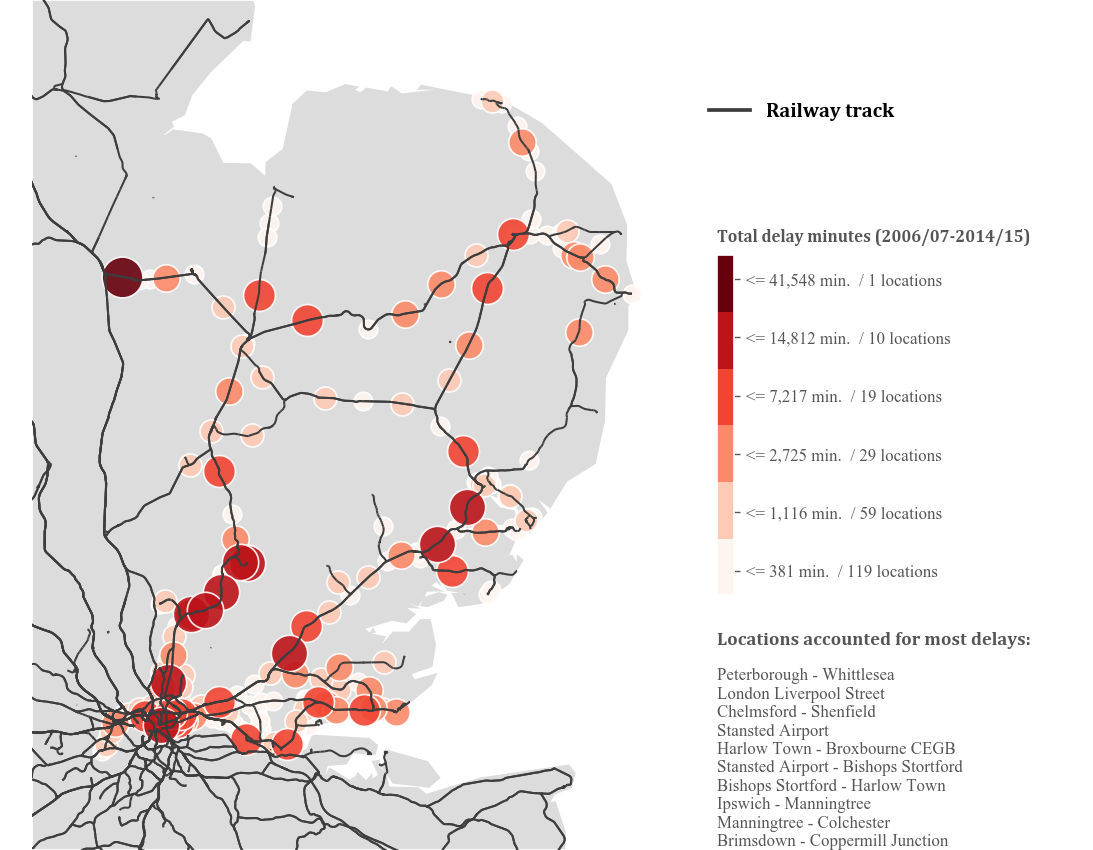

Done.


In [23]:
hotspots_delays(route='ANGLIA', weather='Wind', update=False,
                    seed=123,
                    cmap_name='Reds',
                    show_metex_weather_cells=False,
                    show_osm_landuse_forest=False,
                    show_nr_hazardous_trees=False,
                    save_as="", dpi=None)

### Plot hotspots in terms of incident frequency

In [24]:
def hotspots_frequency(route='ANGLIA', weather='Wind', update=False,
                       seed=123,
                       cmap_name='PuRd',
                       show_metex_weather_cells=False,
                       show_osm_landuse_forest=False,
                       show_nr_hazardous_trees=False,
                       save_as=".png", dpi=None):
    # Get data
    sort_by = ['IncidentCount', 'DelayCost', 'DelayMinutes']
    hotspots_data = get_schedule8_incident_hotspots(route, weather, sort_by, update)
    notnull_data = hotspots_data[hotspots_data.IncidentCount.notnull()]

    # Set a seed number
    pd.np.random.seed(seed)

    # Calculate Jenks natural breaks for delay minutes
    breaks = NBs(y=notnull_data.IncidentCount.values, k=6, initial=100)
    hotspots_data = hotspots_data.join(pd.DataFrame(data={'jenks_bins': breaks.yb}, index=notnull_data.index))

    jenks_labels = ["<= %d  / %d locations" % (b, c) for b, c in zip(breaks.bins, breaks.counts)]

    cmap = plt.get_cmap(cmap_name)  # 'Oranges', 'RdPu', 'Purples'
    colours = cmap(pd.np.linspace(0, 1., len(jenks_labels)))
    marker_size = pd.np.linspace(0.9, 2.1, len(jenks_labels)) * 11

    # Plot basemap (with railway tracks)
    fig, base_map = plot_base_map(legend_loc=(1.05, 0.9))
    fig.subplots_adjust(left=0.001, bottom=0.000, right=0.7715, top=1.000)

    bins = list(breaks.bins)
    for b in range(len(bins)):
        ind1 = hotspots_data.IncidentCount <= bins[b]
        ind2 = hotspots_data.IncidentCount > bins[b - 1]
        if pd.np.isnan(bins[b]):
            plotting_data = hotspots_data[hotspots_data.IncidentCount.isnull()]
        elif bins[b] == pd.np.nanmin(bins):
            plotting_data = hotspots_data[ind1]
        elif bins[b] == pd.np.nanmax(bins):
            plotting_data = hotspots_data[ind2]
        else:
            plotting_data = hotspots_data[ind1 & ind2]

        for i in plotting_data.index:
            mid_lat = plotting_data.MidLatitude[i]
            mid_lon = plotting_data.MidLongitude[i]
            x_mid_pt, y_mid_pt = base_map(mid_lon, mid_lat)
            base_map.plot(x_mid_pt, y_mid_pt, zorder=2,
                          marker='o', color=colours[b], alpha=0.9, markersize=marker_size[b], markeredgecolor='w')

    # Add a colour bar
    cb = colorbar_index(no_of_colours=len(jenks_labels), cmap_param=cmap, shrink=0.4, labels=jenks_labels, pad=0.068)
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_font_properties(matplotlib.font_manager.FontProperties(family='Times New Roman', weight='bold'))
    cb.ax.tick_params(labelsize=10)
    cb.set_alpha(1.0)
    cb.draw_all()

    cb.ax.text(0., 1.025, "Count of incidents (2006/07-2014/15)",
               ha='left', va='bottom', size=10, color='#555555', fontname='Cambria')

    # Show highest frequency, in descending order
    cb.ax.text(0., 0 - 0.16, "Most incident-prone locations: ",
               ha='left', va='bottom', size=11, color='#555555', weight='bold', fontname='Cambria')
    cb.ax.text(0., 0 - 0.75, "\n".join(hotspots_data.StanoxSection[:10]),
               ha='left', va='bottom', size=10, color='#555555', fontname='Times New Roman')

    if show_metex_weather_cells:
        plot_weather_cells(base_map, route=route, legend_loc=(1.05, 0.95))

    if show_osm_landuse_forest:
        plot_osm_forest_and_tree(base_map, add_osm_natural_tree=False, legend_loc=(1.05, 0.96))

    if show_nr_hazardous_trees:
        plot_hazardous_trees(base_map, route=route, legend_loc=(1.05, 0.975))

    save_fig(fig, "frequency", show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees, save_as, dpi)


Plotting the base map ... 

<IPython.core.display.Javascript object>


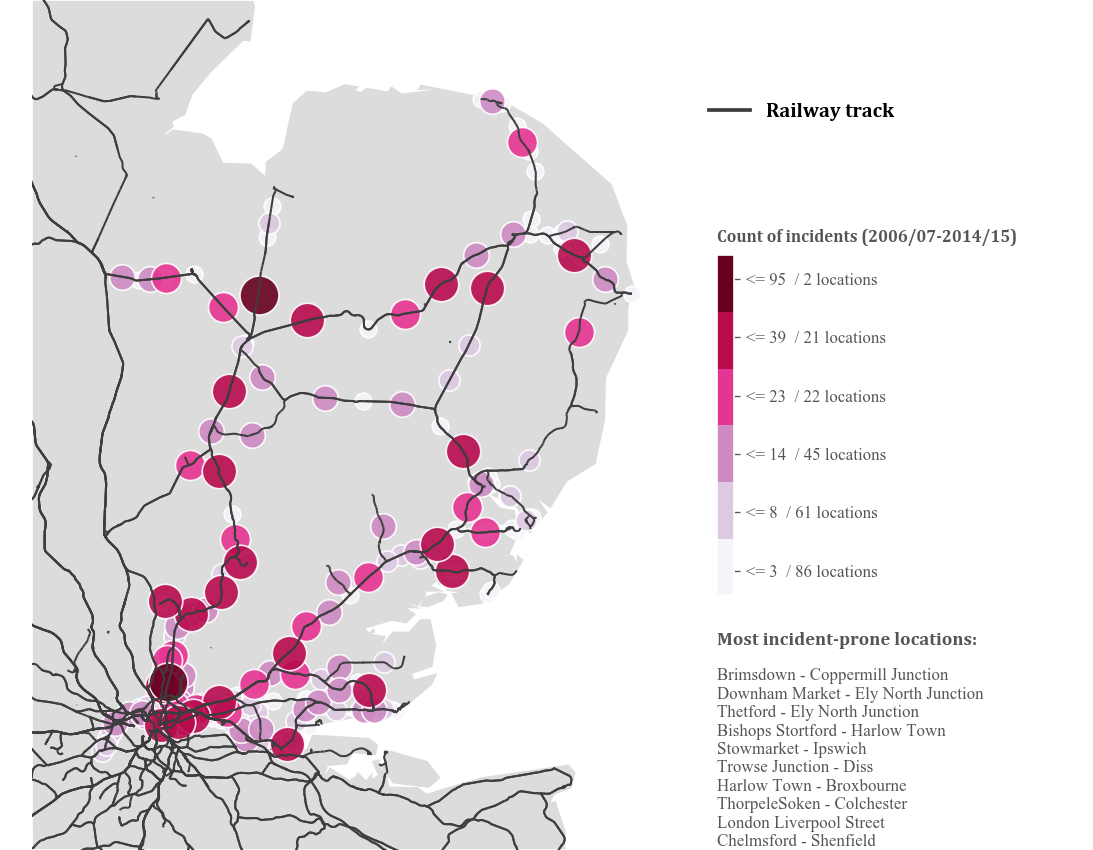

Done.


In [25]:
hotspots_frequency(route='ANGLIA', weather='Wind', update=False,
                       seed=123,
                       cmap_name='PuRd',
                       show_metex_weather_cells=False,
                       show_osm_landuse_forest=False,
                       show_nr_hazardous_trees=False,
                       save_as="", dpi=None)

### Plot hotspots of delay cost

In [26]:
def hotspots_cost(route='ANGLIA', weather='Wind', update=False,
                  seed=123,
                  cmap_name='YlGnBu',
                  show_metex_weather_cells=False,
                  show_osm_landuse_forest=False,
                  show_nr_hazardous_trees=False,
                  save_as=".png", dpi=None):
    # Get data
    sort_by = ['DelayCost', 'IncidentCount', 'DelayMinutes']
    hotspots_data = get_schedule8_incident_hotspots(route, weather, sort_by, update)
    hotspots_data.replace(to_replace={'DelayCost': {0: pd.np.nan}}, inplace=True)
    notnull_data = hotspots_data[hotspots_data.DelayCost.notnull()]

    # Set a seed number
    pd.np.random.seed(seed)

    # Calculate Jenks natural breaks for delay minutes
    breaks = NBs(y=notnull_data.DelayCost.values, k=5, initial=100)
    hotspots_data = hotspots_data.join(pd.DataFrame(data={'jenks_bins': breaks.yb}, index=notnull_data.index))
    # df.drop('jenks_bins', axis=1, inplace=True)
    hotspots_data.jenks_bins.fillna(-1, inplace=True)
    jenks_labels = ['<= £%s  / %s locations' % (format(int(b), ','), c) for b, c in zip(breaks.bins, breaks.counts)]
    jenks_labels.insert(0, 'N/A (no cost)  / %s locations' % len(hotspots_data[hotspots_data['DelayCost'].isnull()]))

    cmap = plt.get_cmap(cmap_name)  # 'RdPu'
    colour_array = pd.np.linspace(0, 1., len(jenks_labels))
    colours = cmap(colour_array)
    marker_size = pd.np.linspace(0.8, 2.3, len(jenks_labels)) * 11

    # Plot basemap (with railway tracks)
    fig, base_map = plot_base_map(legend_loc=(1.05, 0.90))
    fig.subplots_adjust(left=0.001, bottom=0.000, right=0.7715, top=1.000)

    bins = [pd.np.nan] + list(breaks.bins)
    for b in range(len(bins)):
        idx_0 = hotspots_data.DelayCost <= bins[b]
        idx_1 = hotspots_data.DelayCost > bins[b - 1]
        if pd.np.isnan(bins[b]):
            plotting_data = hotspots_data[hotspots_data.DelayCost.isnull()]
        elif bins[b] == pd.np.nanmin(bins):
            plotting_data = hotspots_data[idx_0]
        elif bins[b] == pd.np.nanmax(bins):
            plotting_data = hotspots_data[idx_1]
        else:
            plotting_data = hotspots_data[idx_0 & idx_1]

        for i in plotting_data.index:
            mid_lat = plotting_data.MidLatitude[i]
            mid_lon = plotting_data.MidLongitude[i]
            x_mid_pt, y_mid_pt = base_map(mid_lon, mid_lat)
            base_map.plot(x_mid_pt, y_mid_pt, zorder=2,
                          marker='o', color=colours[b], alpha=0.9,
                          markersize=marker_size[b], markeredgecolor='w', markeredgewidth=1)

    # Add a colour bar
    cb = colorbar_index(no_of_colours=len(jenks_labels), cmap_param=cmap, shrink=0.4, labels=jenks_labels, pad=0.068)
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_font_properties(matplotlib.font_manager.FontProperties(family='Times New Roman', weight='bold'))
    cb.ax.tick_params(labelsize=10)
    cb.set_alpha(1.0)
    cb.draw_all()

    cb.ax.text(0., 1.028, "Compensation payments (2006/07-2014/15)",
               ha='left', va='bottom', size=9, color='#555555', fontname='Cambria')

    # Show highest cost, in descending order
    cb.ax.text(0., 0 - 0.16, "Locations accounted for most cost: ",
               ha='left', va='bottom', size=11, color='#555555', weight='bold', fontname='Cambria')
    cb.ax.text(0., 0 - 0.75, "\n".join(hotspots_data.StanoxSection[:10]),
               ha='left', va='bottom', size=10, color='#555555', fontname='Times New Roman')

    if show_metex_weather_cells:
        plot_weather_cells(base_map, route=route, legend_loc=(1.05, 0.95))

    if show_osm_landuse_forest:
        plot_osm_forest_and_tree(base_map, add_osm_natural_tree=False, legend_loc=(1.05, 0.96))

    if show_nr_hazardous_trees:
        plot_hazardous_trees(base_map, route=route, legend_loc=(1.05, 0.975))

    save_fig(fig, "cost", show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees, save_as, dpi)


Plotting the base map ... 

<IPython.core.display.Javascript object>


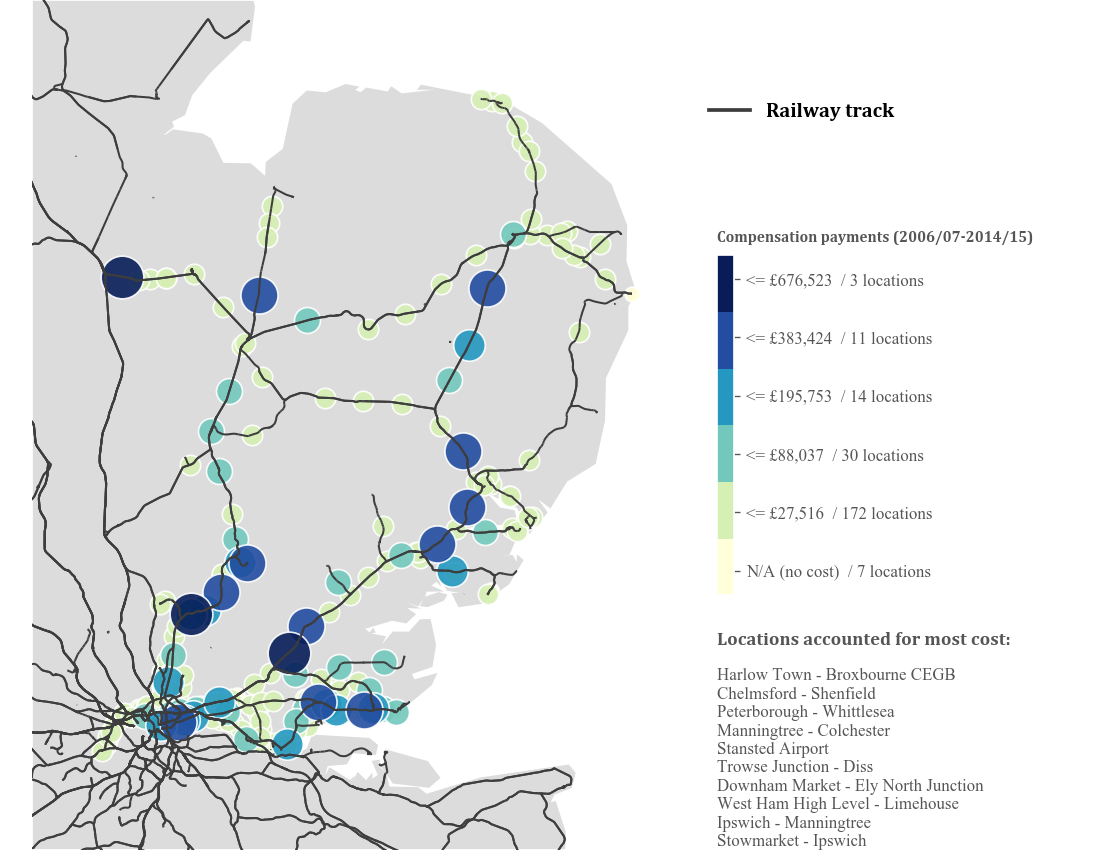

Done.


In [27]:
hotspots_cost(route='ANGLIA', weather='Wind', update=False,
                  seed=123,
                  cmap_name='YlGnBu',
                  show_metex_weather_cells=False,
                  show_osm_landuse_forest=False,
                  show_nr_hazardous_trees=False,
                  save_as="", dpi=None)

### Plot hotspots in terms of delay minutes per incident

In [28]:
def hotspots_delays_per_incident(route='ANGLIA', weather='Wind', update=False,
                                 seed=123,
                                 cmap_name='BrBG',
                                 show_metex_weather_cells=False,
                                 show_osm_landuse_forest=False,
                                 show_nr_hazardous_trees=False,
                                 save_as=".png", dpi=None):
    # Get data
    hotspots_data = get_schedule8_incident_hotspots(route, weather, None, update)
    hotspots_data['DelayMinutesPerIncident'] = hotspots_data.DelayMinutes.div(hotspots_data.IncidentCount)
    hotspots_data.sort_values(by='DelayMinutesPerIncident', ascending=False, inplace=True)

    notnull_data = hotspots_data[hotspots_data.DelayMinutesPerIncident.notnull()]

    # Set a seed number
    pd.np.random.seed(seed)

    # Calculate Jenks natural breaks for delay minutes
    breaks = NBs(y=notnull_data.DelayMinutesPerIncident.values, k=6)
    hotspots_data = hotspots_data.join(pd.DataFrame({'jenks_bins': breaks.yb}, index=notnull_data.index))
    # data['jenks_bins'].fillna(-1, inplace=True)
    jenks_labels = ["<= %s min.  / %s locations" % (format(int(b), ','), c) for b, c in zip(breaks.bins, breaks.counts)]

    cmap = plt.get_cmap(cmap_name)
    colours, marker_size = cmap(pd.np.linspace(0, 1, len(jenks_labels))), pd.np.linspace(1, 2.2, len(jenks_labels)) * 11

    # Plot basemap (with railway tracks)
    fig, base_map = plot_base_map(legend_loc=(1.05, 0.9))
    fig.subplots_adjust(left=0.001, bottom=0.000, right=0.7715, top=1.000)

    bins = list(breaks.bins)
    for b in range(len(bins)):
        idx_0 = hotspots_data.DelayMinutesPerIncident <= bins[b]
        idx_1 = hotspots_data.DelayMinutesPerIncident > bins[b - 1]
        if bins[b] == min(bins):
            plotting_data = hotspots_data[idx_0]
        elif bins[b] == max(bins):
            plotting_data = hotspots_data[idx_1]
        else:
            plotting_data = hotspots_data[idx_0 & idx_1]
        for i in plotting_data.index:
            mid_lat = plotting_data.MidLatitude[i]
            mid_lon = plotting_data.MidLongitude[i]
            mid_x, mid_y = base_map(mid_lon, mid_lat)
            base_map.plot(mid_x, mid_y, zorder=2,
                          marker='o', color=colours[b], alpha=0.9, markersize=marker_size[b], markeredgecolor='w')

    # Add a colour bar
    cb = colorbar_index(no_of_colours=len(jenks_labels), cmap_param=cmap, shrink=0.4, labels=jenks_labels, pad=0.068)
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_font_properties(matplotlib.font_manager.FontProperties(family='Times New Roman', weight='bold'))
    cb.ax.tick_params(labelsize=10)
    cb.set_alpha(1.0)
    cb.draw_all()

    cb.ax.text(0., 1.025, "Delay per incident (2006/07 to 2014/15)",
               ha='left', va='bottom', size=10, color='#555555', fontname='Cambria')

    # Show highest delay min. per incident, in descending order
    cb.ax.text(0., 0 - 0.16, "Longest delays per incident:",
               ha='left', va='bottom', size=11, color='#555555', weight='bold', fontname='Cambria')
    cb.ax.text(0., 0 - 0.75, "\n".join(hotspots_data.StanoxSection[:10]),
               ha='left', va='bottom', size=10, color='#555555', fontname='Times New Roman')

    if show_metex_weather_cells:
        plot_weather_cells(base_map, route=route, legend_loc=(1.05, 0.95))

    if show_osm_landuse_forest:
        plot_osm_forest_and_tree(base_map, add_osm_natural_tree=False, legend_loc=(1.05, 0.96))

    # Show hazardous trees?
    if show_nr_hazardous_trees:
        plot_hazardous_trees(base_map, route=route, legend_loc=(1.05, 0.975))

    save_fig(fig, "delay_per_incident",
             show_metex_weather_cells, show_osm_landuse_forest, show_nr_hazardous_trees, save_as, dpi)


Plotting the base map ... 

<IPython.core.display.Javascript object>


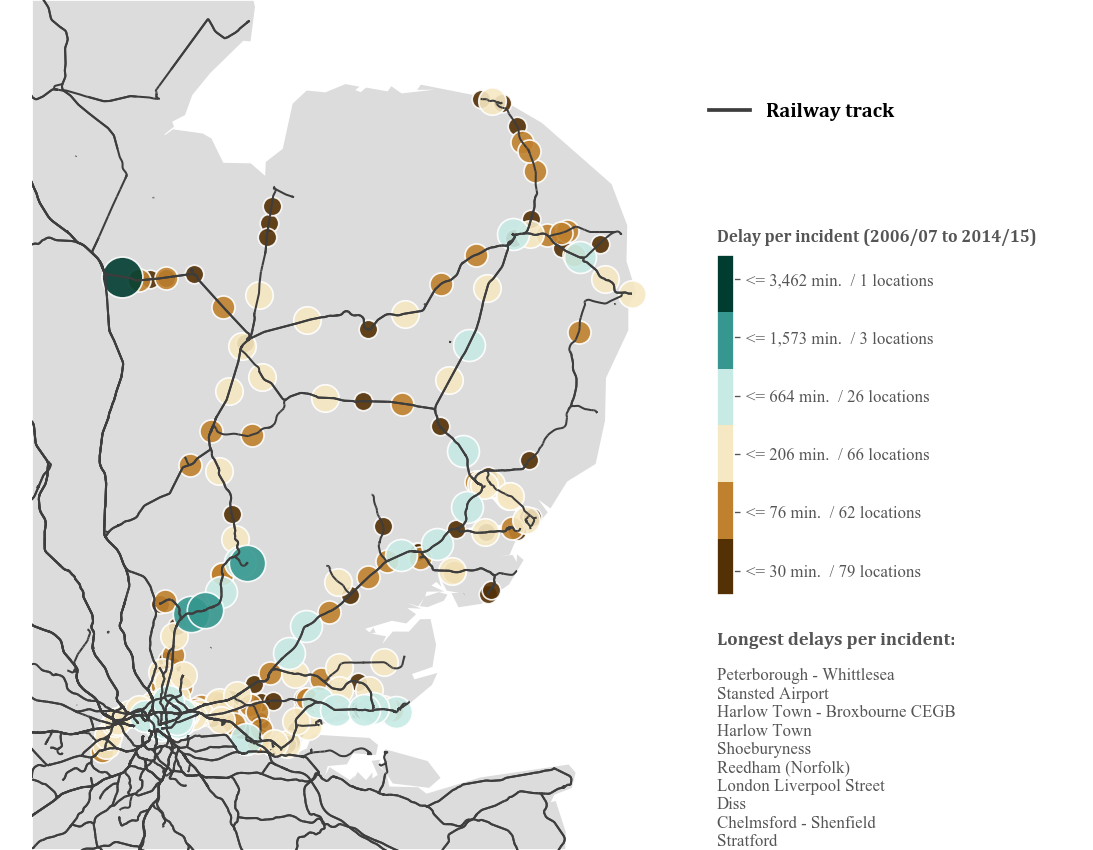

Done.


In [29]:
hotspots_delays_per_incident(route='ANGLIA', weather='Wind', update=False,
                                 seed=123,
                                 cmap_name='BrBG',
                                 show_metex_weather_cells=False,
                                 show_osm_landuse_forest=False,
                                 show_nr_hazardous_trees=False,
                                 save_as="", dpi=None)